# Final Project

MSc in Data Science and Business Analytics - Statistics and Probability 2023/2024
Group 20:
- Giovanni Carboniero (3080265)
- Matteo Casati (3128053)
- Lorenzo Costa (3120759)
- Leonardo Dusini (3141506)
- Fabio Sacerdote (3121315)

## Data import and libraries

In [1]:
import pandas as pd
import numpy as np
import os
from numpy.linalg import multi_dot, inv
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal, gamma
import statsmodels.api as sm
from tabulate import tabulate

In [2]:
input_file_name = os.path.join(os.getcwd(),'SAheart.txt')
with open(input_file_name, 'rt') as input_file:
    data = input_file.read()
    
temp = []
for i in data.splitlines():
    temp.append(i.split())
    
df = pd.DataFrame(temp[1:], columns = [i.strip('"') for i in temp[0]])

for c in df.columns:
    if c != "famhist":
        df[c] = df[c].astype(float)

df['famhist_enc'] = df['famhist'].apply(lambda x: 1 if x=='"Present"' else 0)
df['intercept'] = np.ones(len(df))

In [3]:
Y = np.array(df['chd']).reshape(-1, 1)
X = np.array(df.drop(['chd', 'famhist'], axis = 1))

n, d = X.shape

## Bayesian Probit Regression with MCMC

In a Probit regression (from a Bayesian point of view) we have that:
$$
Y_i | \beta \sim Bernoulli(\Phi(X_i^T\beta)
$$
Therefore the joint distribution of the $Y_i$ can be written as:
$$
    f(Y | \beta, X) = \prod_{i=1}^n [\Phi(X_i^T\beta)]^{Y_i}[1 - \Phi(X_i^T\beta)]^{1-Y_i}
$$
To start inference on $\beta$ we need to put a prior on that parameter. A natural choice in this setting is to use a normal distribution since the parameter can take any value on the real line. We have then that:
$$
p(\beta) \sim N(\mu_0, \Sigma)
$$
and therefore the posterior can be written as:
$$
p(\beta|Y, X) \propto f(Y|\beta,X) p(\beta) \propto e^{\frac{1}{2}(\beta-\mu_0)^T\Sigma^{-1}(\beta-\mu_0)} \prod_{i=1}^n [\Phi(X_i^T\beta)]^{Y_i}[1 - \Phi(X_i^T\beta)]^{1-Y_i}
$$
In general it is easier to work with the log-posterior which has the form:
$$
log(p(\beta|Y, X)) \propto \frac{1}{2}(\beta-\mu_0)^T\Sigma^{-1}(\beta-\mu_0) \sum \Big( Y_i log([\Phi(X_i^T\beta)]) + (1-Y_i) log([1 - \Phi(X_i^T\beta)]) \Big)
$$
This distribution does not have a closed form we can sample from, therefore to obtain an estimate of $\beta$ we have to rely on methods that can approximate it.



The cell below contains a simulated datataset that we used to ensure our algorithm was correct.

In [4]:
#SIMULATED DATA
#X = np.random.normal(0, 1, size=(n,d))
#beta_sim = np.linspace(-1, 1, 10)
#mu = norm.cdf(X@beta_sim)
#Y = np.random.binomial(1, mu)

### Log-Posterior Distribution

The function contained in the block below is the posterior distribution of the parameters $\beta$. **It is written in numpy vectorized form for a better performance.**

In [5]:
#Prior mean:
beta0 = np.zeros(d)

#Prior variance:
V0 = np.identity(d)
eps = 1e-10 

def log_posterior(beta, Y, X, beta0=None, V0=None, eps=1e-9): 
    n, d = X.shape
    if beta0 is None:
        beta0 = np.zeros(d)
    if V0 is None:
        V0 = np.identity(d)
    
    res = 0.0
    norm_cdf = norm.cdf(X @ beta)
    norm_cdf = np.clip(norm_cdf, eps, 1-eps) #to ensure numerical stability with log
    res = Y * np.log(norm_cdf) + (1-Y) * np.log(1-norm_cdf) 
    res = res.sum() + multivariate_normal.logpdf(beta, mean=beta0, cov=V0)
        
    return res

Visualizing how the log-posterior changes as we move further from the "real" values for the coefficients (estimated using a classical probit regression with *statsmodels* library)

In [6]:
import statsmodels.api

model = statsmodels.api.Probit(Y, df.drop(['chd', 'famhist'], axis = 1))
m = model.fit()

Optimization terminated successfully.
         Current function value: 0.510740
         Iterations 6


0.0037893560147838562
0.048219809947162476
0.1028288627753482
0.01239565929055178
0.023555747364073322
-0.04016208232970882
1.955726575982588e-05
0.026269408975054958
0.5389789971254639
-3.5701842913752198


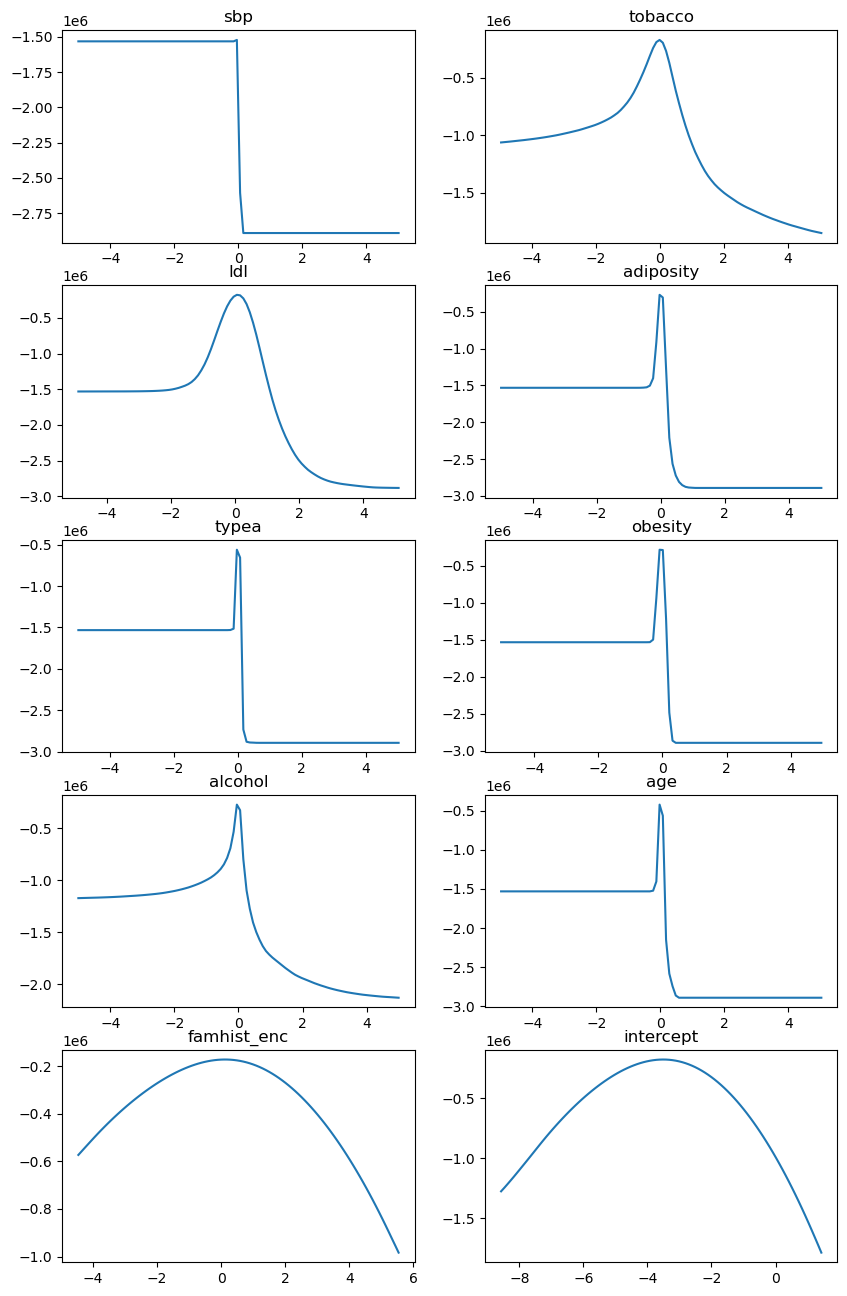

In [7]:
xs = np.linspace(-5, 5, 100)
fig, axs = plt.subplots(5,2,figsize=(10,16))
a = m.params.values
for i in range(10):
    temp = []
    for x in xs:
        t = a.copy()
        t[i] += x
        temp.append(log_posterior(t, Y, X))
    print(a[i])
    axs[i//2, i%2].plot(xs+m.params.values[i], temp)
    axs[i//2, i%2].set_title(m.params.keys()[i])

## Random mcmc metropolis hasting: gaussian proposal

The algorithms we have implemented in teh rest of this notebook are MCMC [Metropolis Hasting](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithms with slightly different settings.\
In this section we have:
- proposal distribution is a Gaussian centered on the previous value of the coefficient
- at each iteration a new value is proposed only for one coefficient chosen at random

As expected, the choice of prior influences a lot the convergence of the algorithm. For instance setting the prior betas to be equal to one the algorithm has trouble correctly indetifying coefficients which are very small, on the other hand setting betas equal to zero convergence for large coefficients is more difficult

In [8]:
from algorithms import MCMC_random
np.random.seed(42)

estimates = []
for i in [1, 0.5, 0.2, 0.01, 0]:
    starting_beta = np.ones(d)*i
    V0 = np.identity(d)*0.5
    V = np.ones(d)*0.01
    sample, acc_rates = MCMC_random(X, Y, starting_beta, V0, log_posterior, V, iterations=5000, verbose=False)
    burnin = 1000
    thinnin = 50
    final_sample = sample[burnin::thinnin,:]
    estimated_beta = np.mean(final_sample, axis=0)
    estimates.append(estimated_beta)

In [9]:
estimates

[array([1.4688376 , 0.93885539, 1.2669256 , 1.04941796, 1.07799497,
        0.92726819, 1.2071578 , 1.02294006, 1.12793145, 0.85543497]),
 array([0.49801275, 0.52050225, 0.34495249, 0.60378892, 0.32517349,
        0.5413934 , 0.57218026, 0.62574754, 0.54772483, 0.72943135]),
 array([ 6.33902381e-02,  1.44451239e-04,  1.45004773e-01,  4.78720790e-02,
        -5.95862272e-02, -7.71838509e-03,  7.13092798e-02,  1.22968125e-01,
         7.70765529e-02,  2.81396818e-01]),
 array([-0.00967952, -0.00436026, -0.00688379,  0.01063391,  0.008586  ,
        -0.0121651 ,  0.00072225,  0.00734627, -0.03614557,  0.26523254]),
 array([-0.00456257,  0.00287557, -0.00153393, -0.00022276, -0.00011707,
         0.0087012 ,  0.00034679,  0.00021811,  0.00341247,  0.00064164])]

We can therefore introduce a bit more of prior knowledge. In particular from previuos tests it seems that the coefficients for the intercept and fam_history are much larger than the others. This intuitively makes sense, family history seems an important factor in predicting a heart attack. \
Clearly it would be even better to introduce some domain knowldge and set better values also for the other parameters.

In [10]:
from algorithms import MCMC_random

starting_beta = np.zeros(d)
#starting_beta[-1] *= -30 #intercept
#starting_beta[-2] *= 1 #fam_history

V0 = np.identity(d)
V = np.array([0.001, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.005, 0.05, 0.05]) #finetuned proposal variances
np.random.seed(1)

sample_norm, acc_rates = MCMC_random(X, Y, starting_beta, V0, log_posterior, V, iterations=250000, verbose=True, decay=True)

25000/250000
[0.03173949 0.05927419 0.07025948 0.02628387 0.01496159 0.02982732
 0.02208835 0.02581686 0.11111111 0.07288401]
50000/250000
[0.02698249 0.0584493  0.06816375 0.02614116 0.01671029 0.02951215
 0.02109281 0.01979208 0.11082877 0.07204895]
75000/250000
[0.02649365 0.05820458 0.06764823 0.02774475 0.01601615 0.02947086
 0.02152721 0.01743412 0.11119915 0.07297546]
100000/250000
[0.02626528 0.05914787 0.0662357  0.02785212 0.01590017 0.02986715
 0.02277996 0.0162081  0.10908366 0.06977897]
125000/250000
[0.02584397 0.06060606 0.06717789 0.02635548 0.01605486 0.03015316
 0.02217546 0.0157298  0.10883706 0.06878599]
150000/250000
[0.06400482 0.13563741 0.13844409 0.06441213 0.03476152 0.06642753
 0.0558489  0.03981919 0.19990677 0.14862905]
175000/250000
[0.09115389 0.18582957 0.19396011 0.09091936 0.04853643 0.09531126
 0.07969508 0.05531188 0.26576396 0.20178785]
200000/250000
[0.10920835 0.22307615 0.2344086  0.1111166  0.05901261 0.11510362
 0.09643182 0.06650677 0.31810211

In [11]:
acc_rates

array([0.13599453, 0.27554554, 0.29369319, 0.13833929, 0.07263107,
       0.14420973, 0.12338658, 0.08532641, 0.38777065, 0.30195876])

The following cells show some graphs used to analyze the results of the algorithm. In particular in the first we look at the convergence of the values and in the second at the autocorrelation between the samples.\
We also use burnin and thinning to discard the first (and most likely imprecise) values sampled and reduce the correlation

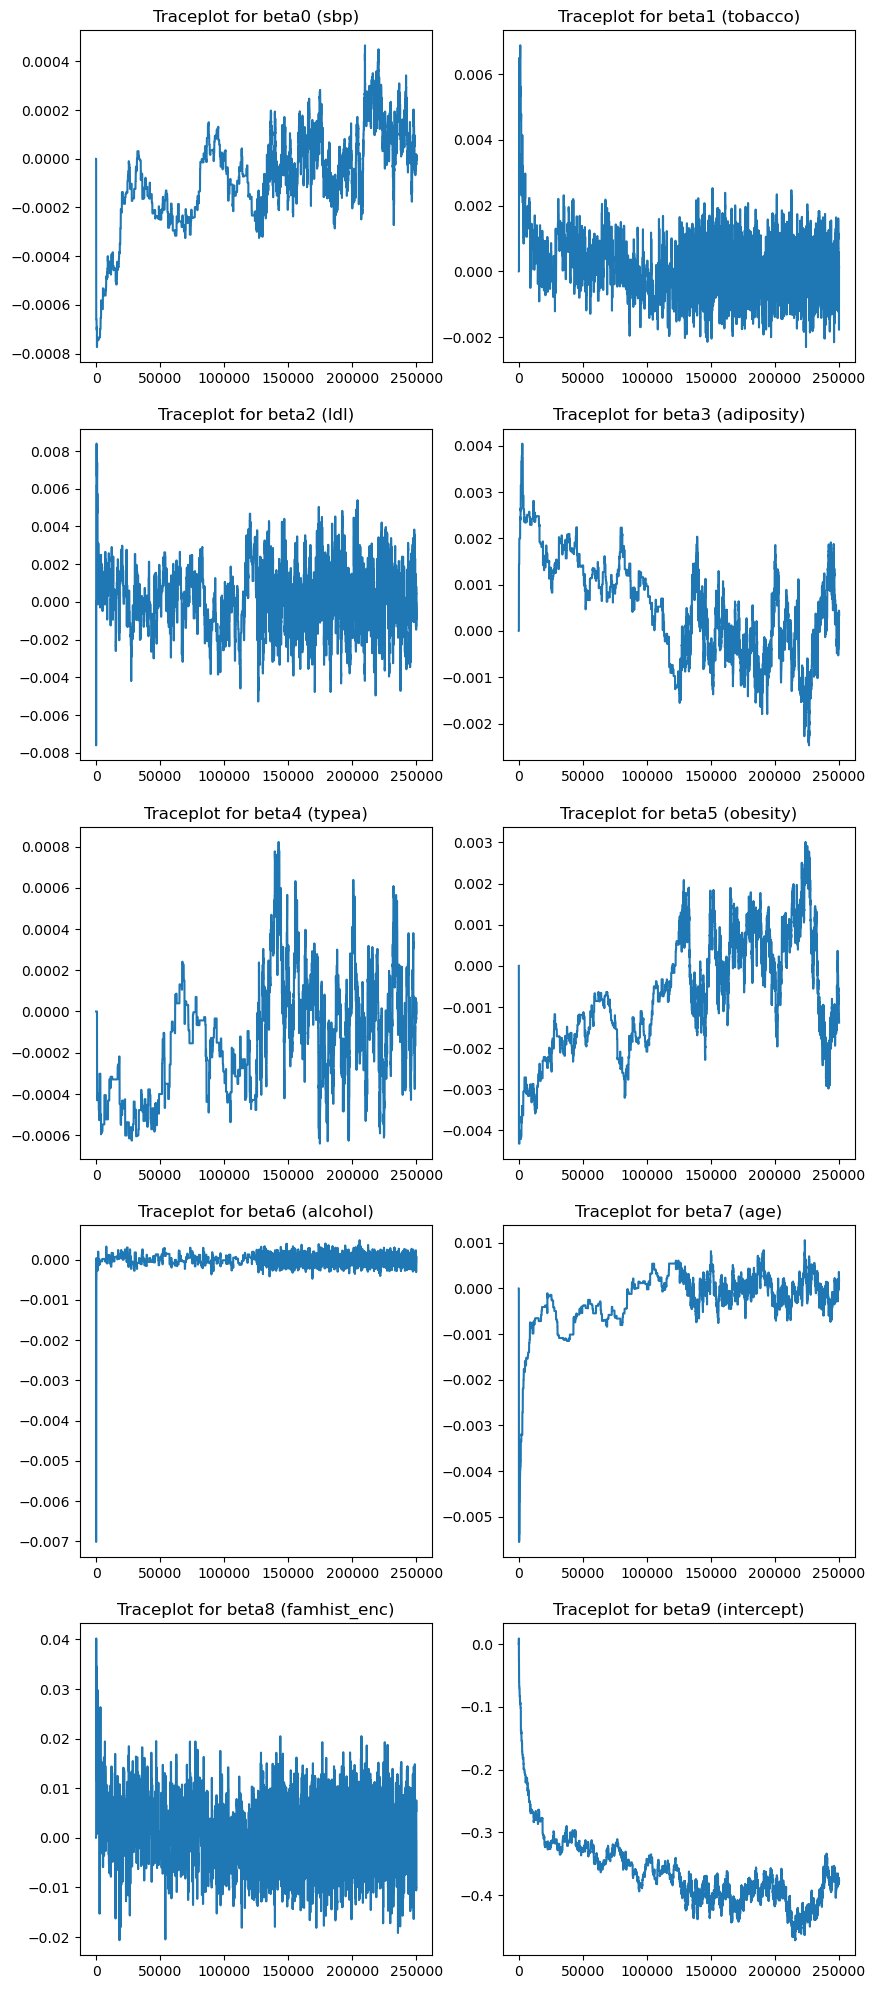

In [12]:
fig, ax = plt.subplots(5, 2, figsize=(10,25))

titles = list(df.columns)
titles.remove("famhist")
titles.remove("chd")

c = 0
for i in range(5):
    for j in range(2):
        title = "Traceplot for beta" + str(c) + " (" + titles[c] + ")"
        ax[i][j].plot(sample_norm[:,c])
        ax[i][j].set_title(title)
        c += 1

Remaining sample size: 0


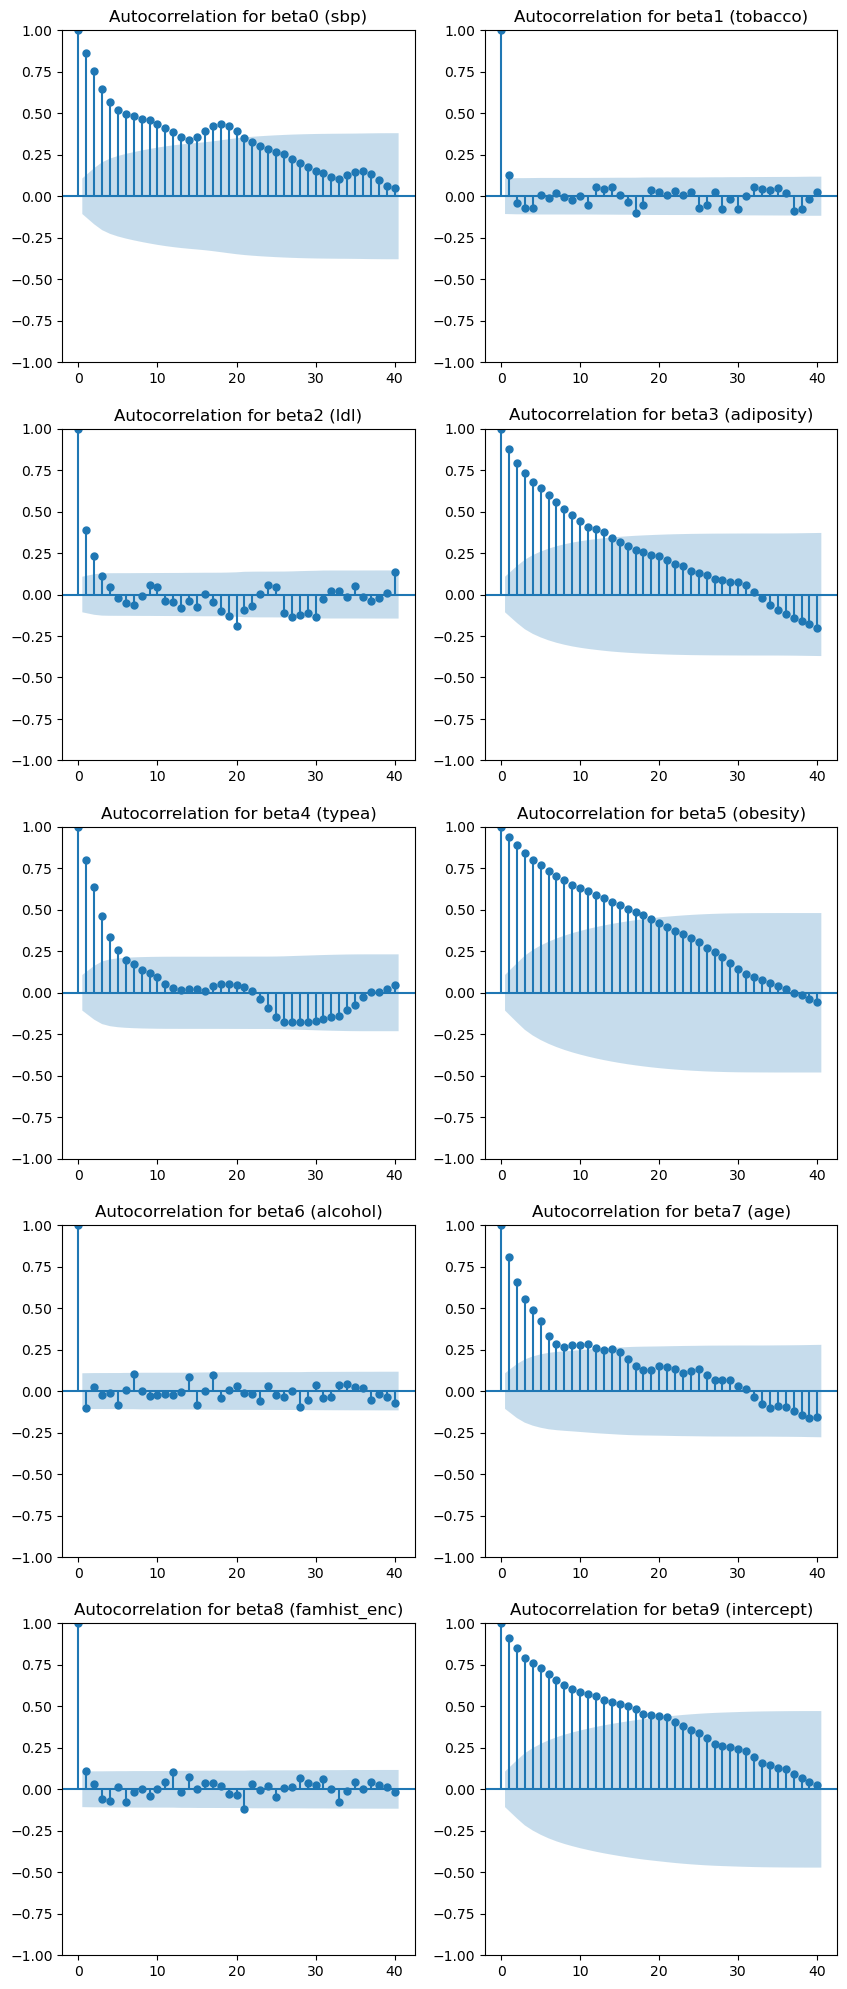

In [13]:
burnin = 150000
thinnin = 300
print("Remaining sample size:", len(sample[burnin::thinnin,0]))

fig, ax = plt.subplots(5, 2, figsize=(10,25))
c = 0
for i in range(5):
    for j in range(2):
        title = "Autocorrelation for beta" + str(c) + " (" + titles[c] + ")"
        sm.graphics.tsa.plot_acf(sample_norm[burnin::thinnin,c], lags=40, ax=ax[i][j])
        ax[i][j].set_title(title)
        c += 1

In [14]:
final_sample = sample_norm[100000::200,:]
estimated_beta_random = np.mean(final_sample, axis=0)
estimated_beta_random

array([-3.20354048e-06, -3.31146165e-05,  1.48373691e-04, -1.29535971e-04,
       -4.41599345e-05,  7.72803819e-05,  3.75809291e-06,  4.51148183e-05,
        1.80355300e-04, -3.93822367e-01])

What emerges from these plots is that despite using 250k iterations (~15mins on my machine) the distribution of some coefficients still has not converged to the statioanry distribution. This can be seen from both the traceplot and the plot of the autocorrelations

### Random MCMC metropolis hasting: uniform proposal

In this section we have:
- proposal distribution is a uniform with extremes set as the previous value of beta $\pm$ an offset value. In addition we also implement the option of decay this offset value as the number of iterations grow as: offset $= c^{it}$ where $i$ is the current iteration, t is computed as: 10/number of iterations and c is an hyperparameter of the model
- same as before only one parameter is chosen to be updated every iteration

In [15]:
from algorithms import MCMC_random_unif

starting_beta = np.zeros(d)
V0 = np.identity(d)
np.random.seed(1)
offset = np.array([0.001, 0.01, 0.04, 0.005, 0.005, 0.005, 0.005, 0.005, 0.1, 0.1]) #finetuned proposal offset

sample_unif, acc_rates = MCMC_random_unif(X, Y, starting_beta, V0, log_posterior, iterations=250000, 
                                     verbose=True, decay=True, offset=offset)

25000/250000
[0.03389831 0.07753797 0.02119853 0.03452478 0.01743715 0.03378378
 0.02443831 0.02403647 0.07536908 0.0511811 ]
50000/250000
[0.03129305 0.07777331 0.02098321 0.0333266  0.01623572 0.03702213
 0.02642034 0.02276423 0.0707668  0.05057977]
75000/250000
[0.03007719 0.0748563  0.02113327 0.03459747 0.01702128 0.03665414
 0.02808237 0.02189389 0.07041878 0.04727756]
100000/250000
[0.03049147 0.07617423 0.02       0.03341596 0.0160048  0.03573945
 0.02922402 0.0218222  0.06847532 0.04740092]
125000/250000
[0.03220612 0.07648153 0.01932406 0.0336355  0.01592127 0.03555627
 0.02952411 0.02159482 0.06848    0.04665234]
150000/250000
[0.07900904 0.16783123 0.05352524 0.08096251 0.04029304 0.08328859
 0.07215811 0.05289421 0.15826191 0.10556519]
175000/250000
[0.11468571 0.23081335 0.07570152 0.1169624  0.06040268 0.12123311
 0.10397029 0.07249028 0.21626248 0.1505928 ]
200000/250000
[0.14012072 0.27791725 0.09160267 0.1441886  0.07296159 0.1490721
 0.1269117  0.08750249 0.26212091 

In [16]:
acc_rates

array([0.17388703, 0.34540781, 0.11463395, 0.18348332, 0.09078257,
       0.18332388, 0.15907178, 0.10853084, 0.324947  , 0.23379017])

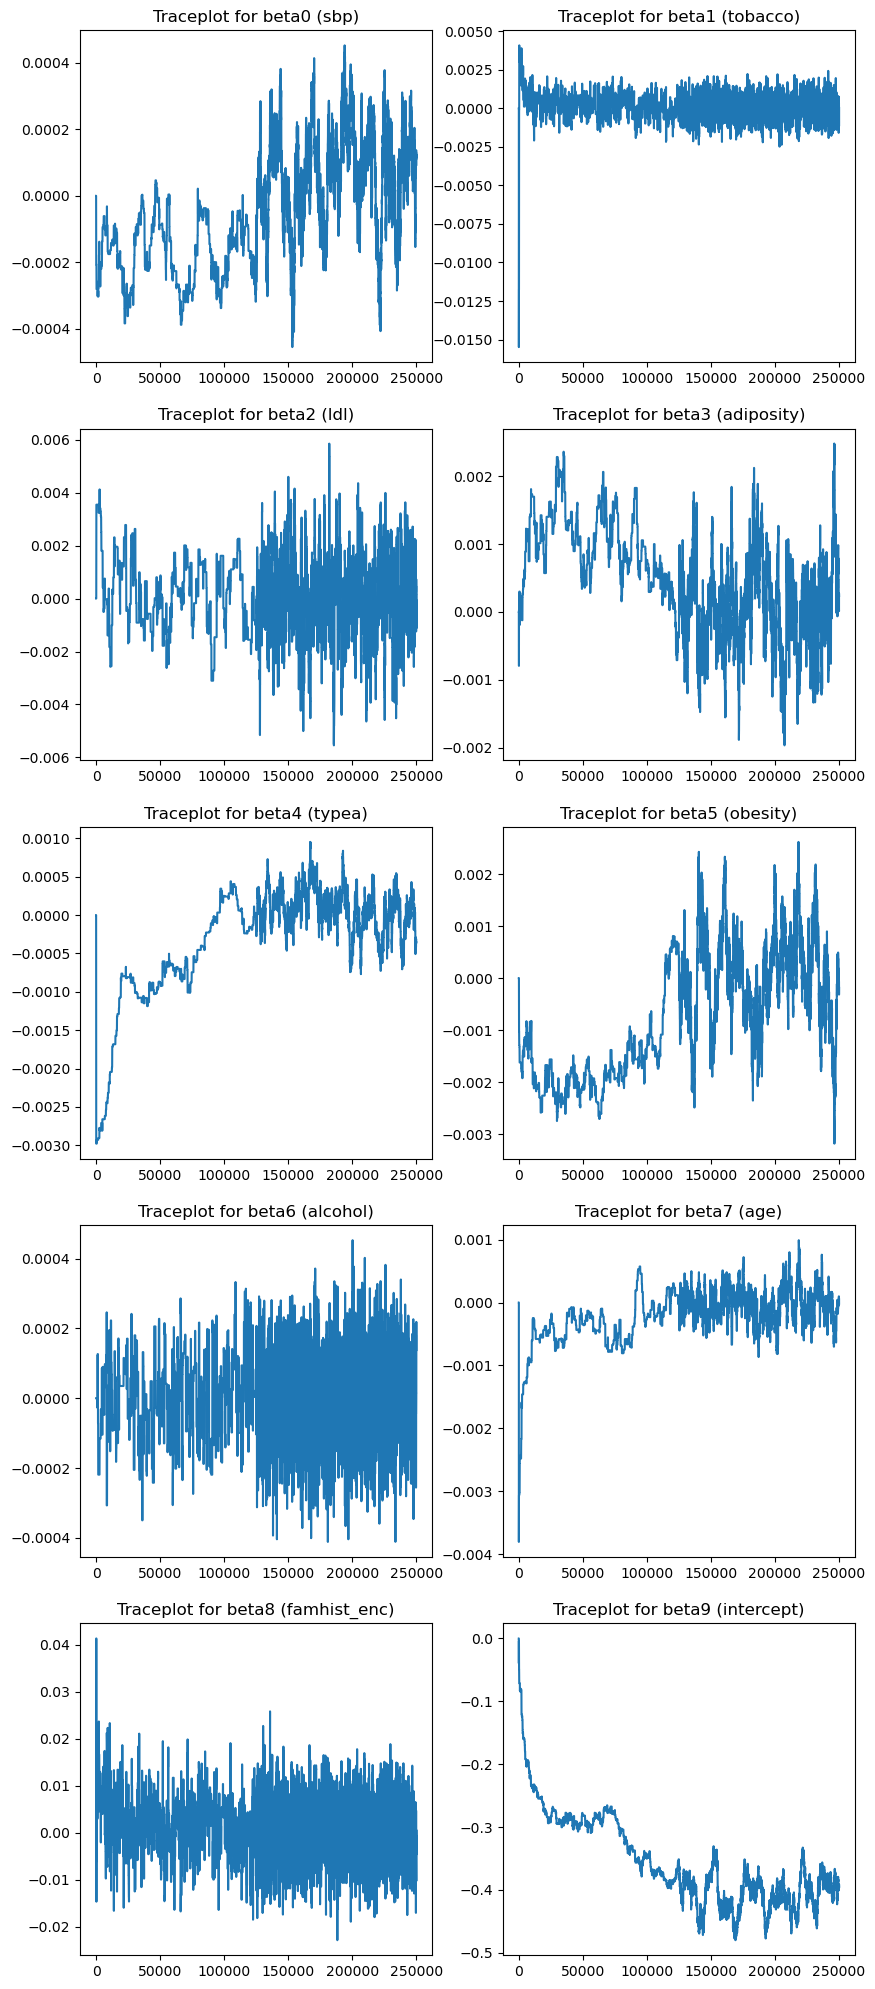

In [17]:
fig, ax = plt.subplots(5, 2, figsize=(10,25))

titles = list(df.columns)
titles.remove("famhist")
titles.remove("chd")

c = 0
for i in range(5):
    for j in range(2):
        title = "Traceplot for beta" + str(c) + " (" + titles[c] + ")"
        ax[i][j].plot(sample_unif[:,c])
        ax[i][j].set_title(title)
        c += 1

Remaining sample size: 0


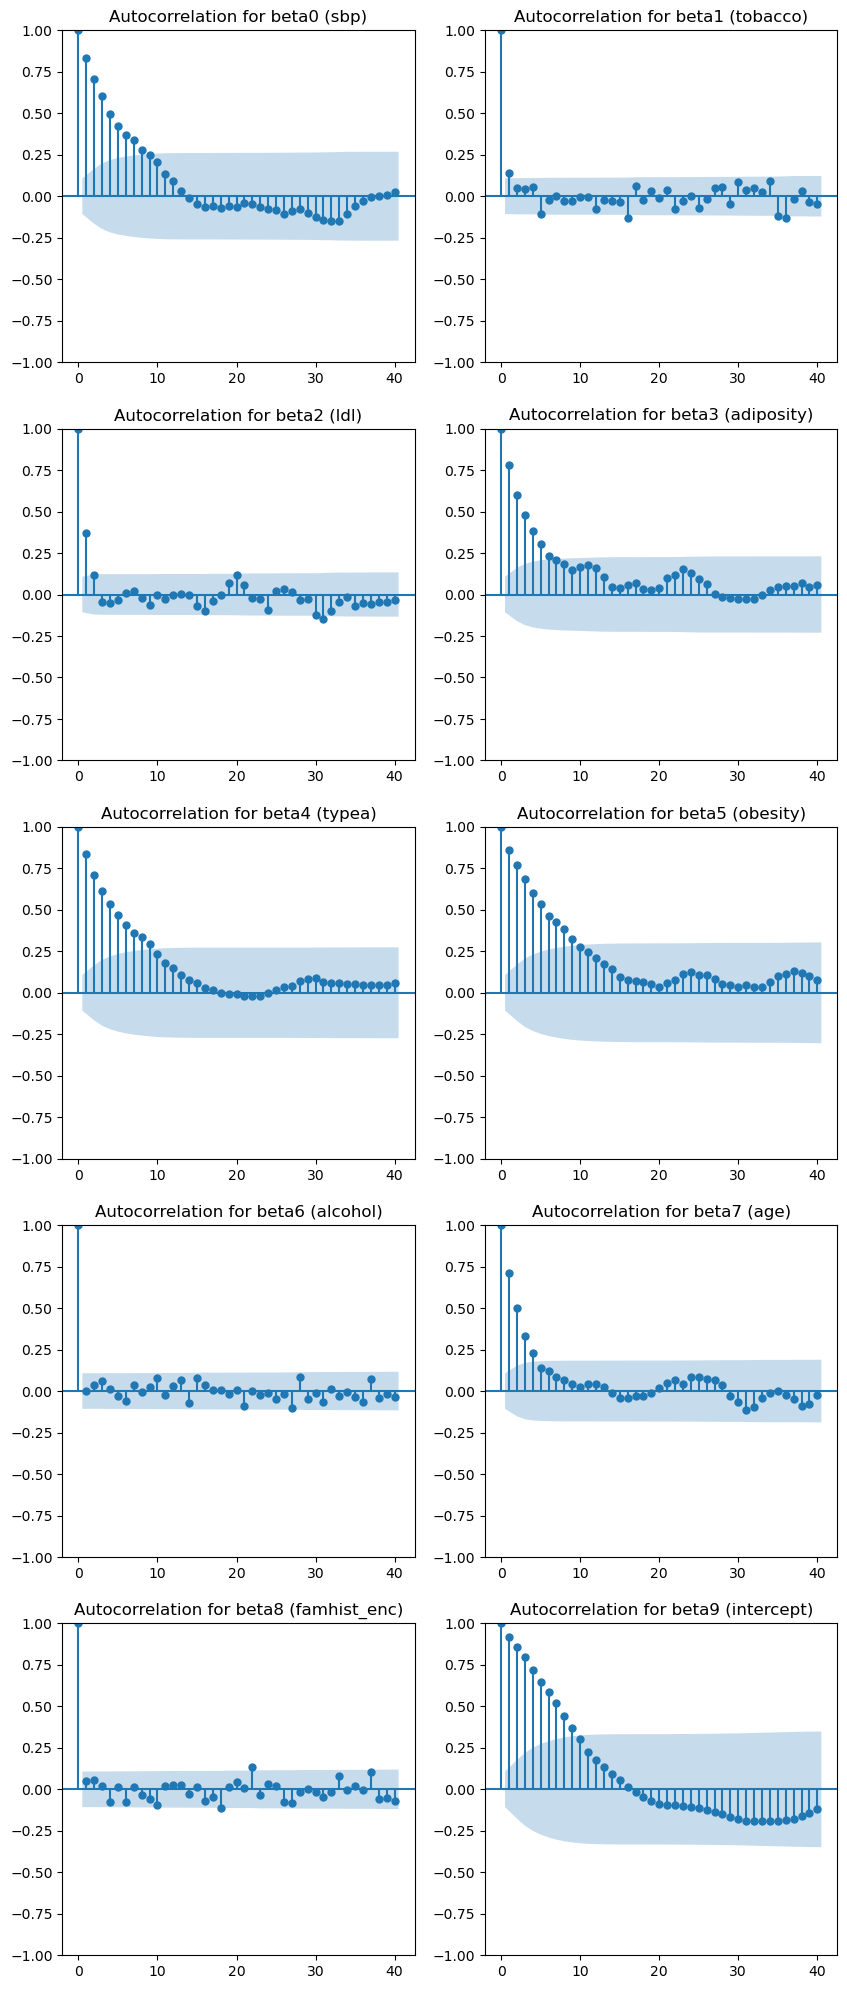

In [18]:
burnin = 150000
thinnin = 300
print("Remaining sample size:", len(sample[burnin::thinnin,0]))

fig, ax = plt.subplots(5, 2, figsize=(10,25))
c = 0
for i in range(5):
    for j in range(2):
        title = "Autocorrelation for beta" + str(c) + " (" + titles[c] + ")"
        sm.graphics.tsa.plot_acf(sample_unif[burnin::thinnin,c], lags=40, ax=ax[i][j])
        ax[i][j].set_title(title)
        c += 1

In [19]:
final_sample = sample_unif[150000::300,:]
estimated_beta_unif = np.mean(final_sample, axis=0)
estimated_beta_unif

array([ 6.35054335e-05,  4.08028841e-05,  2.33853015e-05,  4.50279817e-05,
        5.69447577e-05,  8.45657337e-07, -2.27354196e-06, -3.40422245e-05,
       -1.47652788e-04, -4.06922691e-01])

Similarly some of the coefficients struggle to converge to the stationary distribution, even after 250k iterations (again ~15 min on my computer)

### MCMC Algorithm: Metropolis-within-Gibbs

In this section we implement a Metropolis within Gibbs. This means that at each iteration we sample all the coefficients and compute the posterior using the most recent (i.e. last sampled) values.
We have then:
- proposal distribution is a Gaussian centered on the previous value
- at each iteration we propose a new value for all the coefficients

In [20]:
from algorithms import MCMC_metropolis_hastings

starting_beta = np.zeros(d)

V0 = np.identity(d)
V = np.array([0.00015, 0.005, 0.005, 0.0008, 0.0005, 0.0007, 0.0005, 0.0005, 0.05, 0.01]) #finetuned proposal variances
np.random.seed(42)

sample_gibbs, acc_rates = MCMC_metropolis_hastings(X, Y, starting_beta, V0, 
                                                   log_posterior, V, iterations=50000, verbose=True)

5000/50000
[0.1622 0.1216 0.1312 0.177  0.135  0.1882 0.2332 0.157  0.1104 0.3224]
10000/50000
[0.1653 0.1189 0.1333 0.1681 0.1363 0.193  0.2277 0.1568 0.1119 0.3237]
15000/50000
[0.16726667 0.11726667 0.13306667 0.16493333 0.13546667 0.1884
 0.22993333 0.1562     0.11093333 0.3236    ]
20000/50000
[0.1665  0.11935 0.13325 0.1651  0.13375 0.1863  0.22835 0.15555 0.10995
 0.3244 ]
25000/50000
[0.16628 0.11964 0.13332 0.16384 0.13268 0.18668 0.22868 0.15504 0.1094
 0.3268 ]
30000/50000
[0.16633333 0.11876667 0.13396667 0.16356667 0.13196667 0.18676667
 0.23066667 0.15366667 0.10866667 0.3252    ]
35000/50000
[0.16654286 0.11905714 0.13382857 0.16388571 0.13151429 0.18677143
 0.2306     0.15317143 0.10877143 0.32514286]
40000/50000
[0.16585  0.119225 0.133925 0.164175 0.130925 0.185425 0.229875 0.153475
 0.10905  0.324425]
45000/50000
[0.16608889 0.11962222 0.13488889 0.16371111 0.13097778 0.18491111
 0.22851111 0.15333333 0.10964444 0.32411111]


In [21]:
acc_rates

array([0.16564, 0.1201 , 0.13456, 0.16394, 0.13046, 0.18498, 0.22826,
       0.15392, 0.10952, 0.32372])

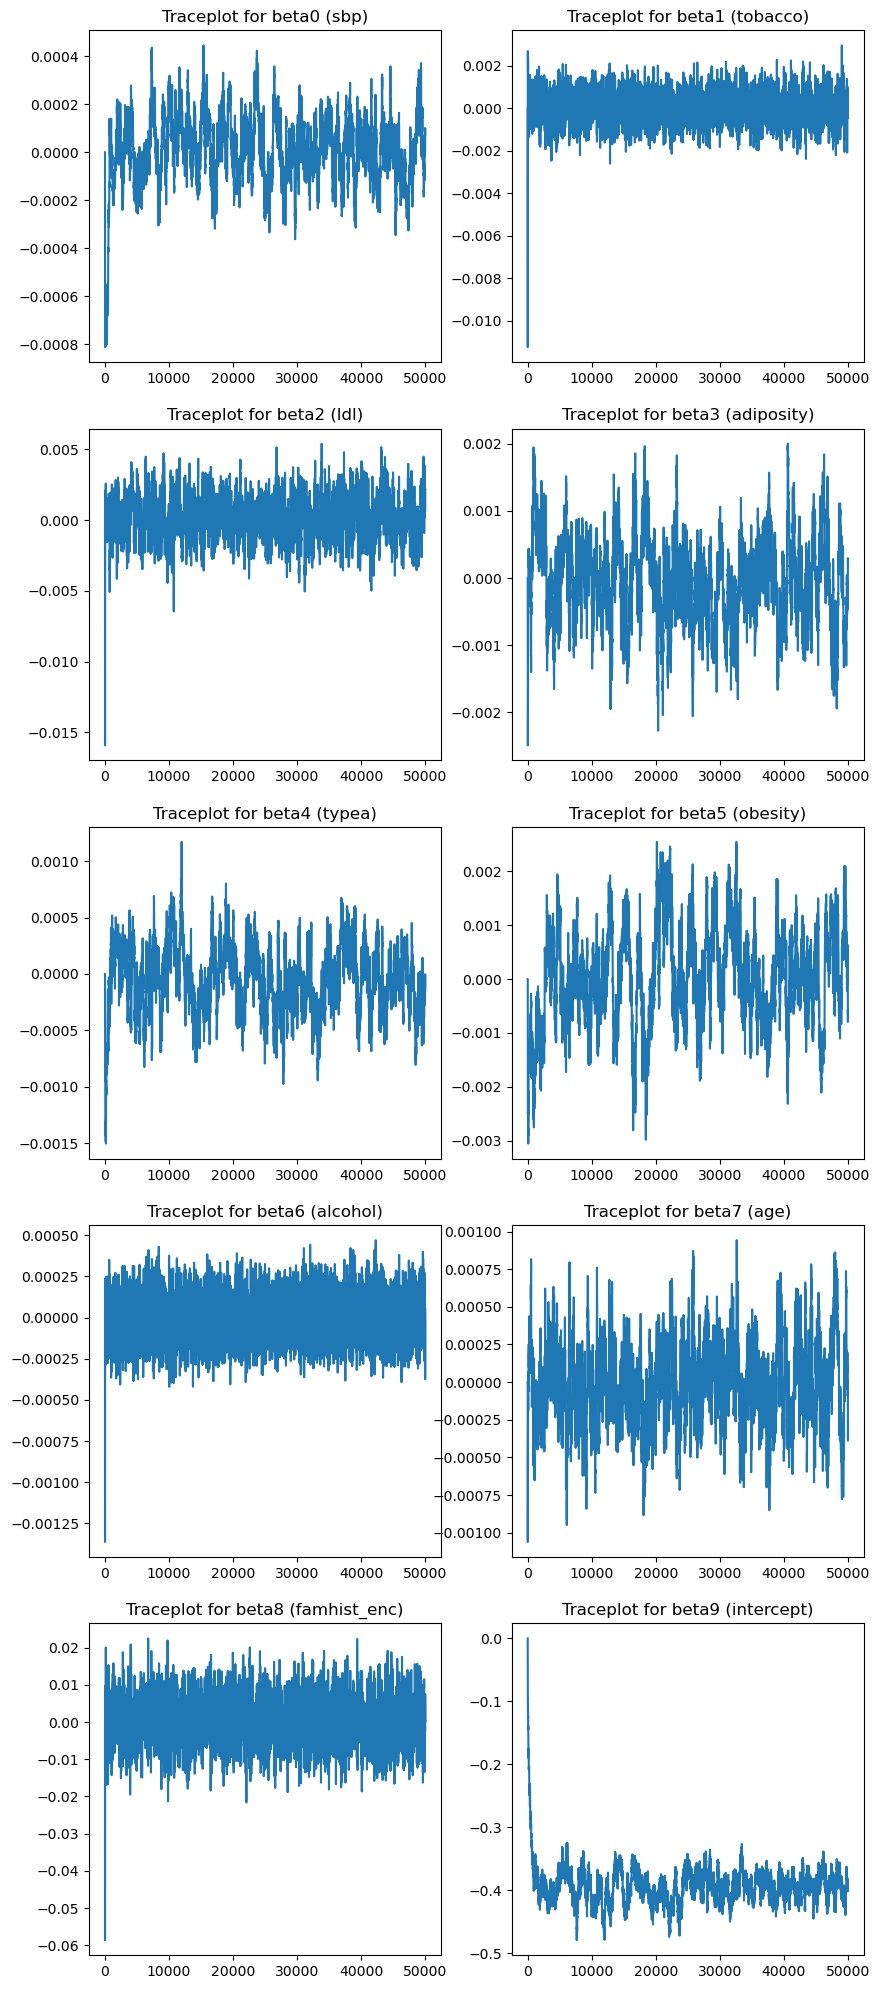

In [22]:
fig, ax = plt.subplots(5, 2, figsize=(10,25))

titles = list(df.columns)
titles.remove("famhist")
titles.remove("chd")

c = 0
for i in range(5):
    for j in range(2):
        title = "Traceplot for beta" + str(c) + " (" + titles[c] + ")"
        ax[i][j].plot(sample_gibbs[:,c])
        ax[i][j].set_title(title)
        c += 1

Remaining sample size: 0


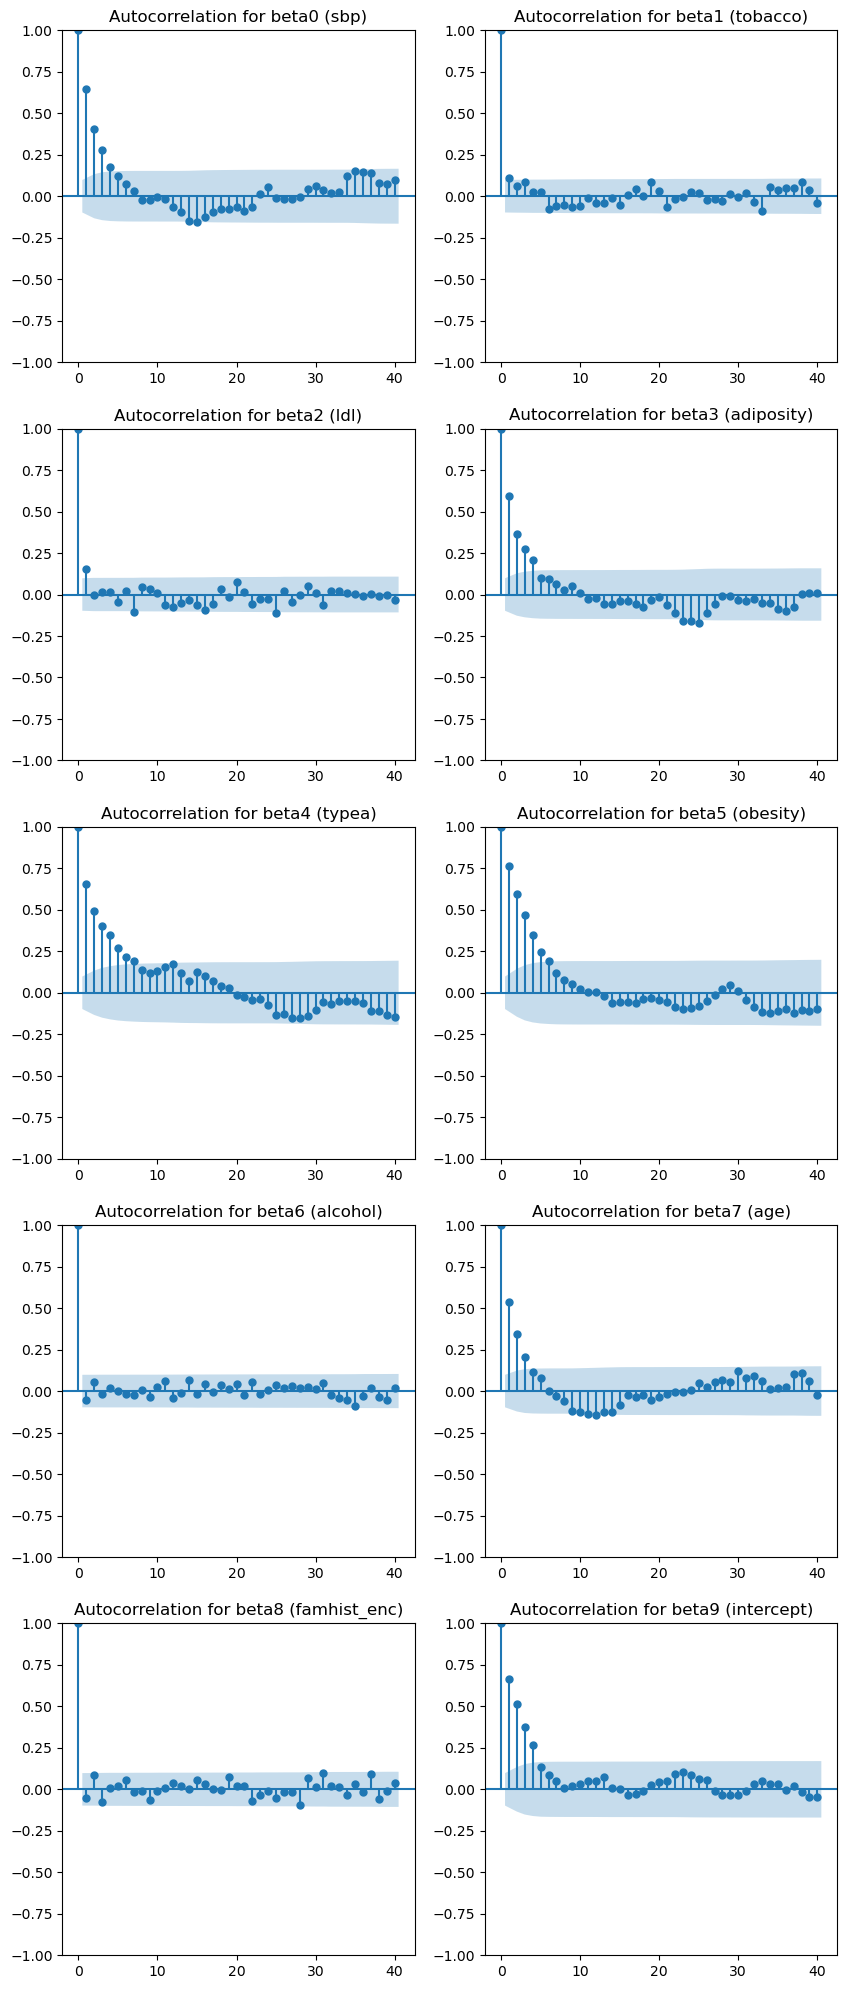

In [23]:
c = 0
burnin = 10000
thinnin = 100
print("Remaining sample size:", len(sample[burnin::thinnin,0]))

fig, ax = plt.subplots(5, 2, figsize=(10,25))

for i in range(5):
    for j in range(2):
        title = "Autocorrelation for beta" + str(c) + " (" + titles[c] + ")"
        sm.graphics.tsa.plot_acf(sample_gibbs[burnin::thinnin,c], lags=40, ax=ax[i][j])
        ax[i][j].set_title(title)
        c += 1

In [24]:
final_sample = sample_gibbs[10000::100,:]
estimated_beta_gibbs = np.mean(final_sample, axis=0)
estimated_beta_gibbs

array([ 2.15430348e-05,  3.04206990e-05,  9.83161506e-05, -1.13087554e-04,
       -4.75320134e-05,  1.27287019e-04, -1.11379358e-05, -1.58849793e-05,
        5.44300736e-04, -3.95845242e-01])

### Results

We see that the two algorithms converge to a similar result (in magnitude at least)

In [25]:
final = pd.DataFrame({'gaussian': estimated_beta_random,
                      'unif':estimated_beta_unif,
                     'gibbs':estimated_beta_gibbs})

final.index = df.drop(['chd', 'famhist'], axis = 1).columns
final

,gaussian,unif,gibbs
sbp,-0.000003,6.350543e-05,0.000022
tobacco,-0.000033,4.080288e-05,0.000030
ldl,0.000148,2.338530e-05,0.000098
adiposity,-0.000130,4.502798e-05,-0.000113
typea,-0.000044,5.694476e-05,-0.000048
obesity,0.000077,8.456573e-07,0.000127
alcohol,0.000004,-2.273542e-06,-0.000011
age,0.000045,-3.404222e-05,-0.000016
famhist_enc,0.000180,-1.476528e-04,0.000544
intercept,-0.393822,-4.069227e-01,-0.395845
